## Stellar-to-Halo-Mass Relation

In this notebook, we estimate the distribution of stellar masses for the red LSBG sample using the photometry and the color-mass-to-light relation. We compare this stellar mass to the subhalo mass we gathered from our NFW profile and MCMC runs. We generate a parameterized version of the stellar-to-halo-mass relation, as described in Moster et al. (2010), and compare our estimate to this curve. 

In [1]:
#Loading packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.stats import norm
from random import sample
import seaborn as sns
import pandas as pd
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');
from astropy.cosmology import Planck15
from astropy import units as u
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Loading Data

We load the LSBG file and pull out the positions, g-magnitudes, g-magnitude error, i-magnitudes, i-magnitude error, r-mangitudes, and r-magnitude errors. We create masks based on the color, red for $g-i>0.6$ and blue for $g-i<0.6$. We  apply the masks to obtain magnitudes for specific color samples. 

In [4]:
#Loading lens file and dataframe
lens_file=pd.read_csv(r'../data/LSBG_catalog_v2.csv')
lens=pd.DataFrame(lens_file, columns= ['ra_se','dec_se', 'mag_gfm_g_corr', 'magerr_gfm_g', 'mag_gfm_i_corr','magerr_gfm_i', 'mag_gfm_r_corr','magerr_gfm_r','r_eff_r'])

In [5]:
#Loading magnitude bands, errors, and masks 
g = lens['mag_gfm_g_corr']
g_err = lens['magerr_gfm_g']

i = lens['mag_gfm_i_corr']
i_err = lens['magerr_gfm_i']

r = lens['mag_gfm_r_corr']
r_err = lens['magerr_gfm_r']

mask_blue = (g-i)<=0.60
mask_red = (g-i)>=0.60
red_lens = lens[mask_red]
blue_lens = lens[mask_blue]

g_red = red_lens['mag_gfm_g_corr']
g_blue = blue_lens['mag_gfm_g_corr']
g_err_red = red_lens['magerr_gfm_g']
g_err_blue = blue_lens['magerr_gfm_g']

i_red = red_lens['mag_gfm_i_corr']
i_blue = blue_lens['mag_gfm_i_corr']
i_err_red = red_lens['magerr_gfm_i']
i_err_blue = blue_lens['magerr_gfm_i']

r_red = red_lens['mag_gfm_r_corr']
r_blue = blue_lens['mag_gfm_r_corr']
r_err_red = red_lens['magerr_gfm_r']
r_err_blue = blue_lens['magerr_gfm_r']

### Stellar Mass Functions

We build functions to calculate the distances to the galaxies, the absolute magnitudes, the colors, the mass-to-light ratios, the luminosities, and the stellar masses. We also include calculations for the propagated error of each of these values based on the uncertainties of the given apparent magnitudes. 

We calculate the distance to the galaxies based on the mean lens redshift, given by the posterior of the MCMC. 

In [6]:
#Calculating distance to objects based on redshift (drawn from MCMC posterior)
def calculate_distance(zl_mean, zl_mean_err, zl_sigma, size):
    zlrange = np.linspace(zl_mean - zl_sigma, zl_mean + 3*zl_sigma, size)
    da = Planck15.comoving_distance(zl_mean)
    da_err = Planck15.comoving_distance(zl_mean_err)
    r_pc = np.array(da.to(u.parsec))
    r_pc_err = np.array(da_err.to(u.parsec)) 
    return r_pc, r_pc_err

We calculate the absolute magnitude with the distance modulus, based on the apparent magnitude and the distance of the galaxies. We also calculate the propagated error of the absolute magnitude based on the distance and apparent magnitude uncertainties.

In [7]:
#Calculating absolute magnitude for objects based on the distance and apparent magnitude
def absolute_magnitude(mag, distance, mag_error, distance_error):
    M_abs = mag-(5*np.log10(distance/10))
    M_abs_err = np.sqrt(mag_error**2 + (distance_error**2)*((-5/(np.log(10)*distance))**2)) #Propagated error for absolute magnitude equation
    return M_abs, M_abs_err

We calculate the color and the color error by finding the difference between two apparent magnitudes and propagating the apparent magnitude uncertainty. 

In [8]:
#Caculating color and color error
def color(mag_1, mag_2, mag_1_err, mag_2_err):
    color = mag_1-mag_2
    color_err = np.sqrt(mag_1_err**2 + mag_2_err**2) #Propagated error for color
    return color, color_err

We calculate the mass-to-light ratio using the color mass-to-light relation (CMLR), as developed in Bell et al. 2003. We also calculate the mass-to-light ratio error by propagating the color error forward from the apparent magnitudes. 

In [9]:
#Calculating the mass-to-light ratio using the color mass-to-light relation (CMLR)
def CMLR(a, b, color, color_err): #a and b are constants for the CMLR
    m_l_ratio = 10**(a + b * (color)) #From Bell et al. 2003
    m_l_ratio_err = np.sqrt((np.log(10)*10**(a+b*color)*b)**2 * color_err**2) #Propagated error 
    return m_l_ratio, m_l_ratio_err

We calculate the luminosity of the galaxies by comparing their absolute magnitudes to the absolute magnitude of the sun. We calculate the luminosity error by propagating forward the absolute magnitude errors. 

In [10]:
#Calculating the luminosity of the objects by comparing them to the solar luminosity
def lum(m_sol, m_abs, m_abs_err):
    lum = 10**(0.4*(m_sol-m_abs))
    lum_err = np.sqrt((np.log(10)*(-0.4)*10**(0.4*(m_sol - m_abs)))**2 * (m_abs_err)**2) #Propagated error
    return lum, lum_err

We multiply the mass-to-light ratio by the luminosity to calculate the stellar mass and propagate forward both the mass-to-light ratio error and the luminosity error. 

In [11]:
#Calculating the stellar mass by comparing the mass-to-light ratio to the luminosity
def stellar_mass(m_l_ratio, lum, m_l_ratio_err, lum_err):
    m_stellar = m_l_ratio*lum
    m_stellar_err = np.sqrt(((lum)**2 * (m_l_ratio_err)**2)+ ((m_l_ratio)**2 * lum_err**2)) #Propagated error 
    return m_stellar, m_stellar_err

### Parameters

We define the parameters and call our functions to determine the stellar mass. The mean lens redshift and lens redshift error come from the posterior of an MCMC. The lens redshift sigma (zl_sigma_red) is used to generate a lens redshift distribution. The designated i-band a and b values are needed for the color mass-to-light relation and come from Bell et al. 2003. The absolute magnitude of the sun is defined for the SDSS i-band filter. 

In [12]:
#Defining constants
zl_mean_red = 13.2e-3
zl_mean_err_red = 0.003
zl_sigma_red = 0.01
a_i = -0.152  
b_i = 0.518 
m_sol = 4.54

We call our functions to calculate the stellar mass. Each function is separated to make editing and testing more intuitive. This produces our stellar mass distribution

In [16]:
#Calling functions
distance_red, distance_err_red = calculate_distance(zl_mean_red, zl_mean_err_red, zl_sigma_red, 7805)
i_abs_red, i_abs_err_red = absolute_magnitude(i_red, distance_red, i_err_red, distance_err_red)
colorgi_red, colorgi_red_err = color(g_red, i_red, g_err_red, i_err_red)
i_ml_ratio_red, i_ml_ratio_err_red = CMLR(a_i, b_i, colorgi_red, colorgi_red_err)
lum_i_red, lum_err_i_red = lum(m_sol, i_abs_red, i_abs_err_red)
m_stellar_red, m_stellar_err_red = stellar_mass(i_ml_ratio_red, lum_i_red, i_ml_ratio_err_red, lum_err_i_red)

### Resampling Magnitudes

We resample the i-band mangitudes to appreciate the spread of the stellar masses over the apparent magnitude uncertainties.  

We first plot a histogram of the i-band apparent magnitudes to understand their distribution. 

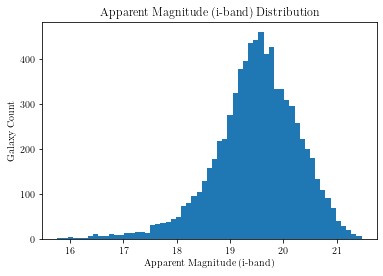

In [18]:
#Getting an idea of the distribution of magnitudes 
plt.hist(i_red, bins='auto')
plt.xlabel('Apparent Magnitude (i-band)')
plt.ylabel('Galaxy Count')
plt.title('Apparent Magnitude (i-band) Distribution')
plt.show()

We produce 10 sets of resampled magnitudes over the apparent magnitude uncertainty. 

In [19]:
#Resampling the magnitudes based on the error
sampled_magnitudes = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes.append(sampled_magnitude)


In [20]:
sampled_magnitudes_v2 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v2 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v2.append(sampled_magnitude_v2)


In [21]:
sampled_magnitudes_v3 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v3 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v3.append(sampled_magnitude_v3)


In [22]:
sampled_magnitudes_v4 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v4 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v4.append(sampled_magnitude_v4)


In [23]:
sampled_magnitudes_v5 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v5 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v5.append(sampled_magnitude_v5)


In [24]:
sampled_magnitudes_v6 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v6 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v6.append(sampled_magnitude_v6)


In [25]:
sampled_magnitudes_v7 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v7 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v7.append(sampled_magnitude_v7)


In [26]:
sampled_magnitudes_v8 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v8 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v8.append(sampled_magnitude_v8)


In [27]:
sampled_magnitudes_v9 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v9 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v9.append(sampled_magnitude_v9)


In [28]:
sampled_magnitudes_v10 = []
for mag, error in zip(i_red, i_err_red):
    sampled_magnitude_v10 = np.random.normal(loc=mag, scale=error)
    sampled_magnitudes_v10.append(sampled_magnitude_v10)


We compare the distribution of the i-band magnitudes to the resampled distributions of the i-band magnitudes to understand the scope of the apparent magnitude uncertainties and their influence. 

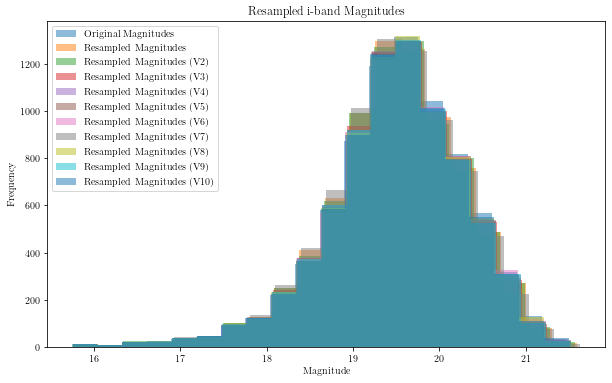

In [29]:
#Plotting the resampled magnitudes
plt.figure(figsize=(10, 6))
plt.hist(i_red, bins=20, alpha=0.5, label="Original Magnitudes")
plt.hist(sampled_magnitudes, bins=20, alpha=0.5, label="Resampled Magnitudes")
plt.hist(sampled_magnitudes_v2, bins=20, alpha=0.5, label="Resampled Magnitudes (V2)")
plt.hist(sampled_magnitudes_v3, bins=20, alpha=0.5, label="Resampled Magnitudes (V3)")
plt.hist(sampled_magnitudes_v4, bins=20, alpha=0.5, label="Resampled Magnitudes (V4)")
plt.hist(sampled_magnitudes_v5, bins=20, alpha=0.5, label="Resampled Magnitudes (V5)")
plt.hist(sampled_magnitudes_v6, bins=20, alpha=0.5, label="Resampled Magnitudes (V6)")
plt.hist(sampled_magnitudes_v7, bins=20, alpha=0.5, label="Resampled Magnitudes (V7)")
plt.hist(sampled_magnitudes_v8, bins=20, alpha=0.5, label="Resampled Magnitudes (V8)")
plt.hist(sampled_magnitudes_v9, bins=20, alpha=0.5, label="Resampled Magnitudes (V9)")
plt.hist(sampled_magnitudes_v10, bins=20, alpha=0.5, label="Resampled Magnitudes (V10)")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title('Resampled i-band Magnitudes')
plt.legend()
plt.show()

We convert the resampled i-band magnitude sets into resampled stellar mass distributions. 

In [30]:
#Calculating the absolute magnitude, luminosity, and stellar mass based on the resampled magnitudes
i_abs_red_sampled, i_abs_err_red_sampled = absolute_magnitude(sampled_magnitudes, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled, lum_err_i_red_sampled = lum(m_sol, i_abs_red_sampled, i_abs_err_red_sampled)
m_stellar_red_sampled, m_stellar_err_red_sampled = stellar_mass(i_ml_ratio_red, lum_i_red_sampled, i_ml_ratio_err_red, lum_err_i_red_sampled)

i_abs_red_sampled_v2, i_abs_err_red_sampled_v2 = absolute_magnitude(sampled_magnitudes_v2, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v2, lum_err_i_red_sampled_v2 = lum(m_sol, i_abs_red_sampled_v2, i_abs_err_red_sampled_v2)
m_stellar_red_sampled_v2, m_stellar_err_red_sampled_v2 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v2, i_ml_ratio_err_red, lum_err_i_red_sampled_v2)

i_abs_red_sampled_v3, i_abs_err_red_sampled_v3 = absolute_magnitude(sampled_magnitudes_v3, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v3, lum_err_i_red_sampled_v3 = lum(m_sol, i_abs_red_sampled_v3, i_abs_err_red_sampled_v3)
m_stellar_red_sampled_v3, m_stellar_err_red_sampled_v3 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v3, i_ml_ratio_err_red, lum_err_i_red_sampled_v3)

i_abs_red_sampled_v4, i_abs_err_red_sampled_v4 = absolute_magnitude(sampled_magnitudes_v4, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v4, lum_err_i_red_sampled_v4 = lum(m_sol, i_abs_red_sampled_v4, i_abs_err_red_sampled_v4)
m_stellar_red_sampled_v4, m_stellar_err_red_sampled_v4 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v4, i_ml_ratio_err_red, lum_err_i_red_sampled_v4)

i_abs_red_sampled_v5, i_abs_err_red_sampled_v5 = absolute_magnitude(sampled_magnitudes_v5, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v5, lum_err_i_red_sampled_v5 = lum(m_sol, i_abs_red_sampled_v5, i_abs_err_red_sampled_v5)
m_stellar_red_sampled_v5, m_stellar_err_red_sampled_v5 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v5, i_ml_ratio_err_red, lum_err_i_red_sampled_v5)

i_abs_red_sampled_v6, i_abs_err_red_sampled_v6 = absolute_magnitude(sampled_magnitudes_v6, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v6, lum_err_i_red_sampled_v6 = lum(m_sol, i_abs_red_sampled_v6, i_abs_err_red_sampled_v6)
m_stellar_red_sampled_v6, m_stellar_err_red_sampled_v6 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v6, i_ml_ratio_err_red, lum_err_i_red_sampled_v6)

i_abs_red_sampled_v7, i_abs_err_red_sampled_v7 = absolute_magnitude(sampled_magnitudes_v7, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v7, lum_err_i_red_sampled_v7 = lum(m_sol, i_abs_red_sampled_v7, i_abs_err_red_sampled_v7)
m_stellar_red_sampled_v7, m_stellar_err_red_sampled_v7 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v7, i_ml_ratio_err_red, lum_err_i_red_sampled_v7)

i_abs_red_sampled_v8, i_abs_err_red_sampled_v8 = absolute_magnitude(sampled_magnitudes_v8, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v8, lum_err_i_red_sampled_v8 = lum(m_sol, i_abs_red_sampled_v8, i_abs_err_red_sampled_v8)
m_stellar_red_sampled_v8, m_stellar_err_red_sampled_v8 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v8, i_ml_ratio_err_red, lum_err_i_red_sampled_v8)

i_abs_red_sampled_v9, i_abs_err_red_sampled_v9 = absolute_magnitude(sampled_magnitudes_v9, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v9, lum_err_i_red_sampled_v9 = lum(m_sol, i_abs_red_sampled_v9, i_abs_err_red_sampled_v9)
m_stellar_red_sampled_v9, m_stellar_err_red_sampled_v9 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v9, i_ml_ratio_err_red, lum_err_i_red_sampled_v9)

i_abs_red_sampled_v10, i_abs_err_red_sampled_v10 = absolute_magnitude(sampled_magnitudes_v10, distance_red, i_err_red, distance_err_red)
lum_i_red_sampled_v10, lum_err_i_red_sampled_v10 = lum(m_sol, i_abs_red_sampled_v10, i_abs_err_red_sampled_v10)
m_stellar_red_sampled_v10, m_stellar_err_red_sampled_v10 = stellar_mass(i_ml_ratio_red, lum_i_red_sampled_v10, i_ml_ratio_err_red, lum_err_i_red_sampled_v10)


We plot the resampled stellar mass distributions derived from the resampled magnitudes and compare to our original stellar mass distribution. 

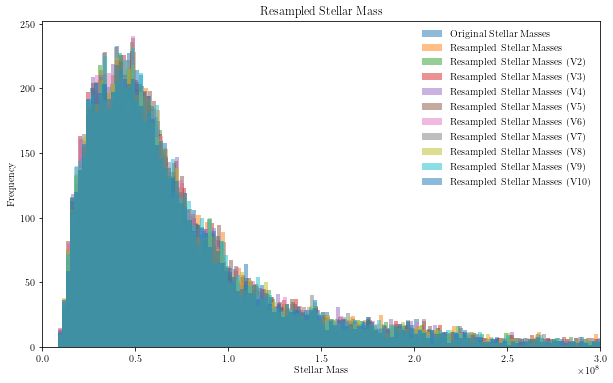

In [34]:
#Plotting the resampled stellar masses derived from the resampled magnitudes
plt.figure(figsize=(10, 6))
plt.hist(m_stellar_red, bins=1000, alpha=0.5, label="Original Stellar Masses")
plt.hist(m_stellar_red_sampled, bins=1000, alpha=0.5, label="Resampled Stellar Masses")
plt.hist(m_stellar_red_sampled_v2, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V2)")
plt.hist(m_stellar_red_sampled_v3, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V3)")
plt.hist(m_stellar_red_sampled_v4, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V4)")
plt.hist(m_stellar_red_sampled_v5, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V5)")
plt.hist(m_stellar_red_sampled_v6, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V6)")
plt.hist(m_stellar_red_sampled_v7, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V7)")
plt.hist(m_stellar_red_sampled_v8, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V8)")
plt.hist(m_stellar_red_sampled_v9, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V9)")
plt.hist(m_stellar_red_sampled_v10, bins=1000, alpha=0.5, label="Resampled Stellar Masses (V10)")
plt.xlabel("Stellar Mass")
plt.ylabel("Frequency")
plt.title('Resampled Stellar Mass')
plt.legend(frameon=False)
plt.xlim(0,0.3e9)
plt.show()

In [35]:
#Printing out the median and standard deviation of the stellar mass distribution
print(np.median(m_stellar_red))
print(np.std(m_stellar_red))

58989714.99021852
129599712.6849919


We calculate the propagated error distribution for the direct calculation of the SHMR, derived from the stellar mass error and the halo mass error (given by the MCMC). 

In [38]:
#Propagated error distribution for direct calculation of SHMR (M_stellar/M_halo)
shmr_error_red = np.sqrt(((1/M_halo_red)**2 * (m_stellar_err_red)**2) + ((-m_stellar_red/M_halo_red**2)**2)*(M_halo_err_red)**2)

### Parameterized Stellar-to-Halo-Mass Relation

In this section, we examine the parameterized stellar-to-halo-mass relation (SHMR), as defined in Moster et al (2010). The parameterized SHMR relies on 4 different parameters, in addition to the halo mass ($M_h$): The characteristic halo mass ($M_\mathrm{char}$), the normalization of the SHMR at the characteristic halo mass ($A$), the slope at the low-mass end of the relation ($\beta$) and the slope at the high-mass end of the relation ($\gamma$). The full relation is defined as: $$\frac{M_*}{M_h} = 2 \times A \times ((\frac{M_h}{M_\mathrm{char}})^{-\beta} + (\frac{M_h}{M_\mathrm{char}})^\gamma)^{-1} $$ These parameters are redshift dependent, thus we select the parameters designed for low-redshift galaxies. We calculate the parameterized SHMR for a range of subhalo masses, from 5e10 to 1e15. 

In [36]:
#Defining parameters for the parameterized stellar-to-halo-mass relation, as defined in Moster et al(2010)
M_halo_red = 9.9e10 #subhalo mass from MCMC posterior distribution 
A = 0.02817 #Normalization of the SHMR at the characteristic halo mass
M_char = 10**11.899 #Characteristic halo mass 
beta= 1.068 #Slope at low-mass end
gamma= 0.611 #Slope at high-mass end
m_halo_ex_red = np.linspace(5e10, 1e15, 100000) #Array of halo masses for the parameterized relation
m_stellar_ex_red = m_halo_ex_red*2 * A * (((m_halo_ex_red/M_char)**(-1*beta)) + ((m_halo_ex_red/M_char)**gamma))**(-1) #Calculation of the parameterized SHMR
M_halo_err_red = 2.2e10 #Error given by the MCMC posterior 

We use the parameter uncertainties to propagate the error for the stellar mass as calculated with the parameterized SHMR. 

In [37]:
#Parameter uncertainties for SHMR
A_up_err = 0.00063
A_low_err = -0.00057
M_char_up_err =  10**(2*0.026)
M_char_low_err =  - 10**(2*0.024)
beta_up_err = 0.051
beta_low_err = -0.044
gamma_up_err = 0.012
gamma_low_err = -0.010

#Propagated error calculations for parameterized SHMR based on parameter uncertainties
m_stellar_err_m_halo = np.sqrt(((-2*A*(m_halo_ex_red/M_char)**(beta)*(-1-beta-(m_halo_ex_red/M_char)**(beta+gamma))+gamma*(m_halo_ex_red/M_char)**(beta+gamma))/(1+ (m_halo_ex_red/M_char)**(beta+gamma))**2)**2 * M_halo_err_red**2)
m_stellar_err_A = np.sqrt(((2*m_halo_ex_red)/((m_halo_ex_red/M_char)**(-1*beta) +(m_halo_ex_red/M_char)**gamma))**2 * (2*0.00063)**2)
m_stellar_err_beta = np.sqrt(((2*A*m_halo_ex_red*(m_halo_ex_red/M_char)**(-1*beta) * np.log(m_halo_ex_red/M_char))/(((m_halo_ex_red/M_char)**(-1*beta) + (m_halo_ex_red/M_char)**gamma)**2))**2 * (2*0.051)**2)
m_stellar_err_gamma = np.sqrt((-2*A*m_halo_ex_red*((m_halo_ex_red/M_char)**gamma)*np.log(m_halo_ex_red/M_char)/((m_halo_ex_red/M_char)**(-1*beta) + (m_halo_ex_red/M_char)**gamma)**2)**2 * (2*0.012)**2)
m_stellar_M_char = np.sqrt((-2*A*m_halo_ex_red*(((beta*m_halo_ex_red*(m_halo_ex_red/M_char)**(-1*beta -1))/M_char**2) - ((gamma*m_halo_ex_red*(m_halo_ex_red/M_char)**(gamma-1))/M_char**2))/(((m_halo_ex_red/M_char)**(-1*beta) + (m_halo_ex_red/M_char)**gamma)**2))**2 * (10**(2*0.026))**2)

m_stellar_ex_red_err_prop = m_stellar_err_m_halo + m_stellar_err_A + m_stellar_err_beta + m_stellar_err_gamma + m_stellar_M_char

We define the error range for the halo mass (based on the MCMC posterior) and construct an array of halo masses the same size as the galaxy sample

In [39]:
y=np.array([1])
asymmetric_error = [2.2e10*y, 0*y] #Error for halo mass
M_halo_red_arr = np.array(M_halo_red) #Array conversions for formatting
M_halo_red_arr = np.resize(M_halo_red_arr, 7805)

We compare the parameterized SHMR to the calculated SHMR for this work at the median, max, and mean of the stellar mass distribution, with errorbars derived from propagation. 

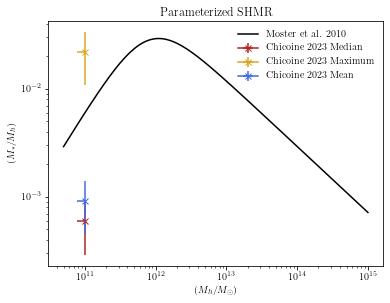

In [41]:
#Plot comparing the parameterized SHMR to the SHMR for this work with errorbars derived from propagation
fig = plt.figure(figsize=(6,4.5))
plt.plot((m_halo_ex_red), (m_stellar_ex_red/m_halo_ex_red), color='black', label='Moster et al. 2010')
plt.errorbar(M_halo_red, np.median(m_stellar_red)/M_halo_red, xerr = asymmetric_error, yerr = np.median(shmr_error_red), marker='x', color='firebrick', label='Chicoine 2023 Median')
plt.errorbar(M_halo_red, np.max(m_stellar_red)/M_halo_red, xerr = asymmetric_error, yerr = np.max(shmr_error_red), marker='x', color='goldenrod', label='Chicoine 2023 Maximum')
plt.errorbar(M_halo_red, np.mean(m_stellar_red)/M_halo_red, xerr = asymmetric_error, yerr = np.mean(shmr_error_red), marker='x', color='royalblue', label='Chicoine 2023 Mean')
plt.xlabel('$(M_h/M_{\odot})$')
plt.ylabel('$(M_*/M_h)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)
plt.title('Parameterized SHMR')
plt.show()


### Parameterized SHMR Error

We calculate the error range of the parameterized SHMR by resampling over the parameter uncertainties at various halo masses. 

In [44]:
#Obtaining the errorbars of the parameterized SHMR
#Calculation of parameterized SHMR at various masses
m_stellar_ex_red_1 = 5e10 * 2 * A * (((5e10/M_char)**(-1*beta)) + ((5e10/M_char)**gamma))**(-1)
m_stellar_ex_red_2 = 7e10 * 2 * A * (((7e10/M_char)**(-1*beta)) + ((7e10/M_char)**gamma))**(-1)
m_stellar_ex_red_2 = 1e11 * 2 * A * (((1e11/M_char)**(-1*beta)) + ((1e11/M_char)**gamma))**(-1)
m_stellar_ex_red_4 = 3e11 * 2 * A * (((3e11/M_char)**(-1*beta)) + ((3e11/M_char)**gamma))**(-1)
m_stellar_ex_red_3 = 5e11 * 2 * A * (((5e11/M_char)**(-1*beta)) + ((5e11/M_char)**gamma))**(-1)
m_stellar_ex_red_6 = 7e11 * 2 * A * (((7e11/M_char)**(-1*beta)) + ((7e11/M_char)**gamma))**(-1)
m_stellar_ex_red_4 = 1e12 * 2 * A * (((1e12/M_char)**(-1*beta)) + ((1e12/M_char)**gamma))**(-1)
m_stellar_ex_red_8 = 3e12 * 2 * A * (((3e12/M_char)**(-1*beta)) + ((3e12/M_char)**gamma))**(-1)
m_stellar_ex_red_5 = 5e12 * 2 * A * (((5e12/M_char)**(-1*beta)) + ((5e12/M_char)**gamma))**(-1)
m_stellar_ex_red_10 = 7e12 * 2 * A * (((7e12/M_char)**(-1*beta)) + ((7e12/M_char)**gamma))**(-1)
m_stellar_ex_red_6 = 1e13 * 2 * A * (((1e13/M_char)**(-1*beta)) + ((1e13/M_char)**gamma))**(-1)
m_stellar_ex_red_12 = 3e13 * 2 * A * (((3e13/M_char)**(-1*beta)) + ((3e13/M_char)**gamma))**(-1)
m_stellar_ex_red_7 = 5e13 * 2 * A * (((5e13/M_char)**(-1*beta)) + ((5e13/M_char)**gamma))**(-1)
m_stellar_ex_red_14 = 7e13 * 2 * A * (((7e13/M_char)**(-1*beta)) + ((7e13/M_char)**gamma))**(-1)
m_stellar_ex_red_8 = 1e14 * 2 * A * (((1e14/M_char)**(-1*beta)) + ((1e14/M_char)**gamma))**(-1)
m_stellar_ex_red_16 = 3e14 * 2 * A * (((3e14/M_char)**(-1*beta)) + ((3e14/M_char)**gamma))**(-1)
m_stellar_ex_red_9 = 5e14 * 2 * A * (((5e14/M_char)**(-1*beta)) + ((5e14/M_char)**gamma))**(-1)
m_stellar_ex_red_18 = 7e14 * 2 * A * (((7e14/M_char)**(-1*beta)) + ((7e14/M_char)**gamma))**(-1)
m_stellar_ex_red_10 = 1e15 * 2 * A * (((1e15/M_char)**(-1*beta)) + ((1e15/M_char)**gamma))**(-1)

#Creating a list of the stellar masses calculated with the parameterized SHMR
m_stellar_ex_red_points = [m_stellar_ex_red_1, m_stellar_ex_red_2, m_stellar_ex_red_3, m_stellar_ex_red_4, m_stellar_ex_red_5, m_stellar_ex_red_6, m_stellar_ex_red_7, m_stellar_ex_red_8, m_stellar_ex_red_9, m_stellar_ex_red_10]

#We define the error on the parameters for the parameterized SHMR as 2x error to get the broader errorbands
A_err = 2*0.00063
M_char_err = 2*10**0.026
beta_err = 2*0.051
gamma_err = 2*0.012

#We resample the SHMR and stellar mass over the uncertainties of the parameters for various masses

sampled_stellar_mass_1 = []
for i in range(10000):
    A_samp = np.random.normal(loc=A, scale=A_err)
    beta_samp = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_1 = 5e10 * 2 * A_samp * (((5e10/M_char_samp)**(-1*beta_samp)) + ((5e10/M_char_samp)**gamma_samp))**(-1)
    sampled_stellar_mass_1.append(sampled_stellar_mass_obj_1)

sampled_stellar_mass_2 = []
for i in range(10000):
    A_samp_2 = np.random.normal(loc=A, scale=A_err)
    beta_samp_2 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_2 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_2 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_2 = 7e10 * 2 * A_samp_2 * (((7e10/M_char_samp_2)**(-1*beta_samp_2)) + ((7e10/M_char_samp_2)**gamma_samp_2))**(-1)
    sampled_stellar_mass_2.append(sampled_stellar_mass_obj_2)

sampled_stellar_mass_3 = []
for i in range(10000):
    A_samp_3 = np.random.normal(loc=A, scale=A_err)
    beta_samp_3 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_3 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_3 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_3 = 1e11 * 2 * A_samp_3 * (((1e11/M_char_samp_3)**(-1*beta_samp_3)) + ((1e11/M_char_samp_3)**gamma_samp_3))**(-1)
    sampled_stellar_mass_3.append(sampled_stellar_mass_obj_3)
    
sampled_stellar_mass_4 = []
for i in range(10000):
    A_samp_4 = np.random.normal(loc=A, scale=A_err)
    beta_samp_4 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_4 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_4 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_4 = 3e11 * 2 * A_samp_4 * (((3e11/M_char_samp_4)**(-1*beta_samp_4)) + ((3e11/M_char_samp_4)**gamma_samp_4))**(-1)
    sampled_stellar_mass_4.append(sampled_stellar_mass_obj_4)

sampled_stellar_mass_5 = []
for i in range(10000):
    A_samp_5 = np.random.normal(loc=A, scale=A_err)
    beta_samp_5 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_5 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_5 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_5 = 5e11 * 2 * A_samp_5 * (((5e11/M_char_samp_5)**(-1*beta_samp_5)) + ((5e11/M_char_samp_5)**gamma_samp_5))**(-1)
    sampled_stellar_mass_5.append(sampled_stellar_mass_obj_5)
    
sampled_stellar_mass_6 = []
for i in range(10000):
    A_samp_6 = np.random.normal(loc=A, scale=A_err)
    beta_samp_6 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_6 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_6 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_6 = 7e11 * 2 * A_samp_6 * (((7e11/M_char_samp_6)**(-1*beta_samp_6)) + ((7e11/M_char_samp_6)**gamma_samp_6))**(-1)
    sampled_stellar_mass_6.append(sampled_stellar_mass_obj_6)

sampled_stellar_mass_7 = []
for i in range(10000):
    A_samp_7 = np.random.normal(loc=A, scale=A_err)
    beta_samp_7 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_7 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_7 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_7 = 1e12 * 2 * A_samp_7 * (((1e12/M_char_samp_7)**(-1*beta_samp_7)) + ((1e12/M_char_samp_7)**gamma_samp_7))**(-1)
    sampled_stellar_mass_7.append(sampled_stellar_mass_obj_7)

sampled_stellar_mass_8 = []
for i in range(10000):
    A_samp_8 = np.random.normal(loc=A, scale=A_err)
    beta_samp_8 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_8 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_8 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_8 = 3e12 * 2 * A_samp_8 * (((3e12/M_char_samp_8)**(-1*beta_samp_8)) + ((3e12/M_char_samp_8)**gamma_samp_8))**(-1)
    sampled_stellar_mass_8.append(sampled_stellar_mass_obj_8)


sampled_stellar_mass_9 = []
for i in range(10000):
    A_samp_9 = np.random.normal(loc=A, scale=A_err)
    beta_samp_9 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_9 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_9 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_9 = 5e12 * 2 * A_samp_9 * (((5e12/M_char_samp_9)**(-1*beta_samp_9)) + ((5e12/M_char_samp_9)**gamma_samp_9))**(-1)
    sampled_stellar_mass_9.append(sampled_stellar_mass_obj_9)

sampled_stellar_mass_10 = []
for i in range(10000):
    A_samp_10 = np.random.normal(loc=A, scale=A_err)
    beta_samp_10 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_10 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_10 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_10 = 7e12 * 2 * A_samp_10 * (((7e12/M_char_samp_10)**(-1*beta_samp_10)) + ((7e12/M_char_samp_10)**gamma_samp_10))**(-1)
    sampled_stellar_mass_10.append(sampled_stellar_mass_obj_10)

sampled_stellar_mass_11 = []
for i in range(10000):
    A_samp_11 = np.random.normal(loc=A, scale=A_err)
    beta_samp_11 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_11 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_11 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_11 = 1e13 * 2 * A_samp_11 * (((1e13/M_char_samp_11)**(-1*beta_samp_11)) + ((1e13/M_char_samp_11)**gamma_samp_11))**(-1)
    sampled_stellar_mass_11.append(sampled_stellar_mass_obj_11)
    
sampled_stellar_mass_12 = []
for i in range(10000):
    A_samp_12 = np.random.normal(loc=A, scale=A_err)
    beta_samp_12 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_12 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_12 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_12 = 3e13 * 2 * A_samp_12 * (((3e13/M_char_samp_12)**(-1*beta_samp_12)) + ((3e13/M_char_samp_12)**gamma_samp_12))**(-1)
    sampled_stellar_mass_12.append(sampled_stellar_mass_obj_12)

sampled_stellar_mass_13 = []
for i in range(10000):
    A_samp_13 = np.random.normal(loc=A, scale=A_err)
    beta_samp_13 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_13 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_13 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_13 = 5e13 * 2 * A_samp_13 * (((5e13/M_char_samp_13)**(-1*beta_samp_13)) + ((5e13/M_char_samp_13)**gamma_samp_13))**(-1)
    sampled_stellar_mass_13.append(sampled_stellar_mass_obj_13)

sampled_stellar_mass_14 = []
for i in range(10000):
    A_samp_14 = np.random.normal(loc=A, scale=A_err)
    beta_samp_14 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_14 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_14 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_14 = 7e13 * 2 * A_samp_14 * (((7e13/M_char_samp_14)**(-1*beta_samp_14)) + ((7e13/M_char_samp_14)**gamma_samp_14))**(-1)
    sampled_stellar_mass_14.append(sampled_stellar_mass_obj_14)

sampled_stellar_mass_15 = []
for i in range(10000):
    A_samp_15 = np.random.normal(loc=A, scale=A_err)
    beta_samp_15 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_15 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_15 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_15 = 1e14 * 2 * A_samp_15 * (((1e14/M_char_samp_15)**(-1*beta_samp_15)) + ((1e14/M_char_samp_15)**gamma_samp_15))**(-1)
    sampled_stellar_mass_15.append(sampled_stellar_mass_obj_15)

sampled_stellar_mass_16 = []
for i in range(10000):
    A_samp_16 = np.random.normal(loc=A, scale=A_err)
    beta_samp_16 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_16 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_16 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_16 = 3e14 * 2 * A_samp_16 * (((3e14/M_char_samp_16)**(-1*beta_samp_16)) + ((3e14/M_char_samp_16)**gamma_samp_16))**(-1)
    sampled_stellar_mass_16.append(sampled_stellar_mass_obj_16)


sampled_stellar_mass_17 = []
for i in range(10000):
    A_samp_17 = np.random.normal(loc=A, scale=A_err)
    beta_samp_17 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_17 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_17 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_17 = 5e14 * 2 * A_samp_17 * (((5e14/M_char_samp_17)**(-1*beta_samp_17)) + ((5e14/M_char_samp_17)**gamma_samp_17))**(-1)
    sampled_stellar_mass_17.append(sampled_stellar_mass_obj_17)

sampled_stellar_mass_18 = []
for i in range(10000):
    A_samp_18 = np.random.normal(loc=A, scale=A_err)
    beta_samp_18 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_18 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_18 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_18 = 7e14 * 2 * A_samp_18 * (((7e14/M_char_samp_18)**(-1*beta_samp_18)) + ((7e14/M_char_samp_18)**gamma_samp_18))**(-1)
    sampled_stellar_mass_18.append(sampled_stellar_mass_obj_18)
    
sampled_stellar_mass_19 = []
for i in range(10000):
    A_samp_19 = np.random.normal(loc=A, scale=A_err)
    beta_samp_19 = np.random.normal(loc=beta, scale=beta_err)
    gamma_samp_19 = np.random.normal(loc=gamma, scale=gamma_err)
    M_char_samp_19 = np.random.normal(loc=M_char, scale=M_char_err)
    sampled_stellar_mass_obj_19 = 1e15 * 2 * A_samp_19 * (((1e15/M_char_samp_19)**(-1*beta_samp_19)) + ((1e15/M_char_samp_19)**gamma_samp_19))**(-1)
    sampled_stellar_mass_19.append(sampled_stellar_mass_obj_19)


We plot the histograms of the resampled stellar masses derived from the parameterized SHMR 

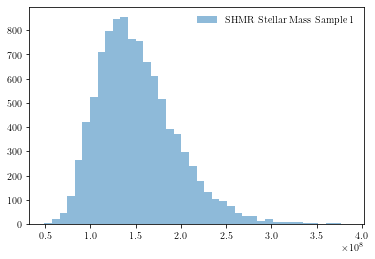

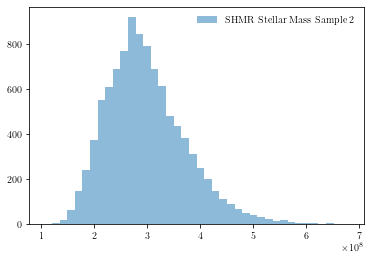

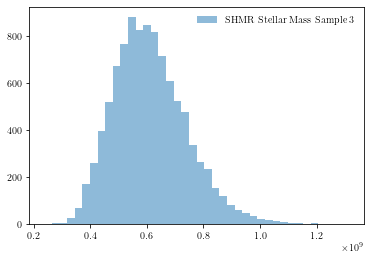

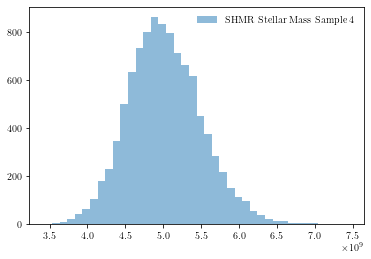

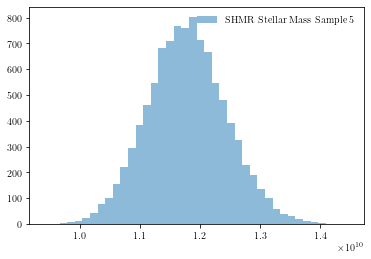

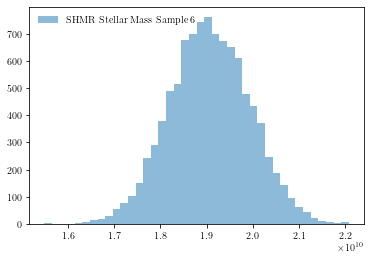

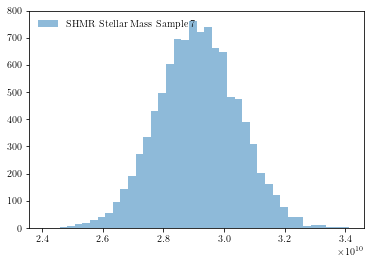

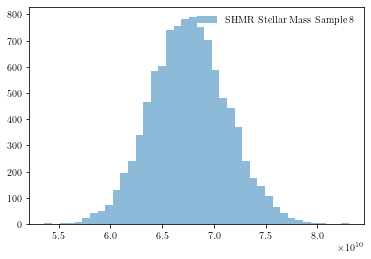

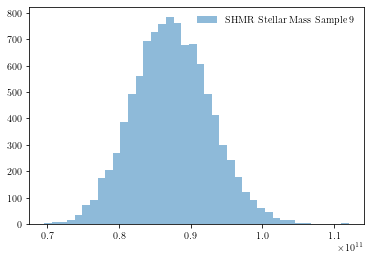

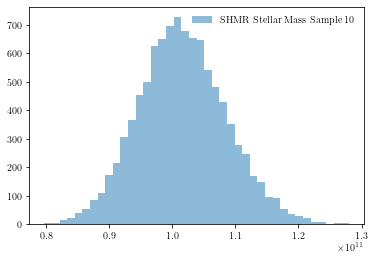

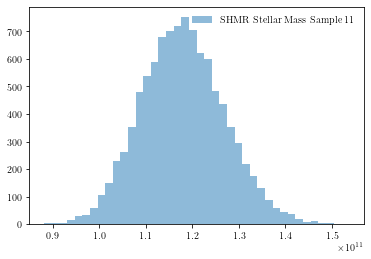

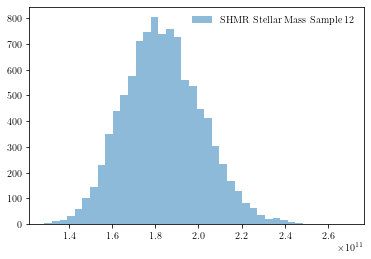

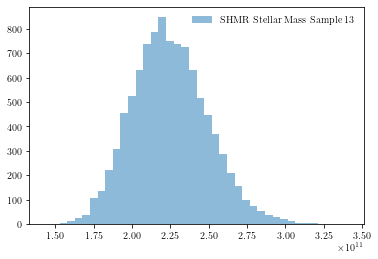

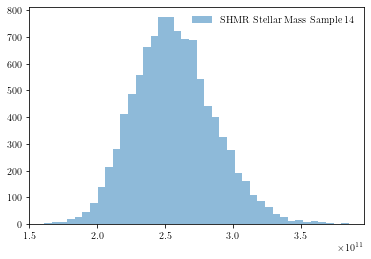

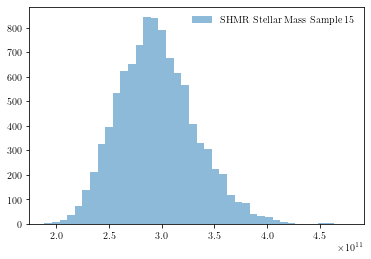

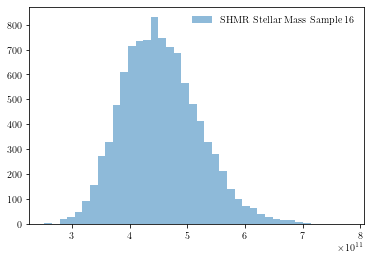

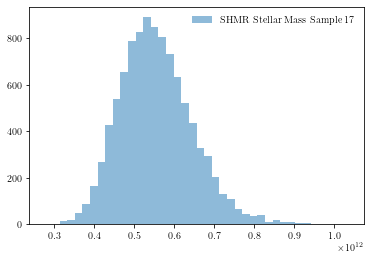

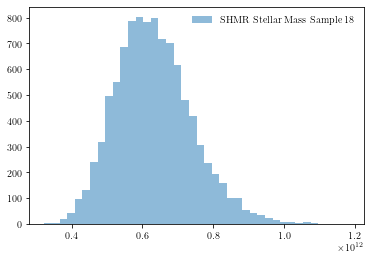

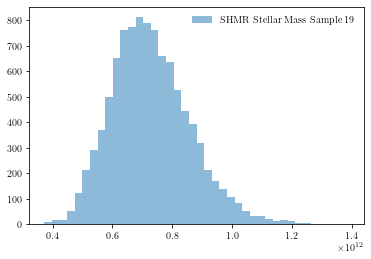

In [45]:
#We show the histograms of the resampled stellar masses derived from the parameterized SHMR
plt.hist(sampled_stellar_mass_1, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 1")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_2, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 2")
plt.legend(frameon=False)
plt.show()


plt.hist(sampled_stellar_mass_3, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 3")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_4, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 4")
plt.legend(frameon=False)
plt.show()


plt.hist(sampled_stellar_mass_5, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 5")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_6, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 6")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_7, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 7")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_8, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 8")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_9, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 9")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_10, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 10")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_11, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 11")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_12, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 12")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_13, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 13")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_14, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 14")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_15, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 15")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_16, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 16")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_17, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 17")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_18, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 18")
plt.legend(frameon=False)
plt.show()

plt.hist(sampled_stellar_mass_19, bins=40, alpha=0.5, label="SHMR Stellar Mass Sample 19")
plt.legend(frameon=False)
plt.show()

We define the upper and lower bounds of the stellar mass values derived from the resampled parameterized SHMR and the halo masses at which we calculate the stellar mass. We plot these upper and lower bounds to show the uncertainty of the parameterized SHMR. We plot the distribution of our estimate of the LSBG SHMR as a violin plot to show the full range of possible stellar masses. 

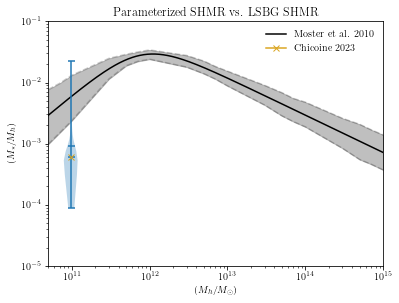

In [47]:
#We define the spread of the stellar mass values derived from the resampled parameterized SHMR
sampled_stellar_mass_1_spread = [np.min(sampled_stellar_mass_1)*y/5e10, np.max(sampled_stellar_mass_1)*y/5e10]
sampled_stellar_mass_2_spread = [np.min(sampled_stellar_mass_2)*y/7e10, np.max(sampled_stellar_mass_2)*y/7e10]
sampled_stellar_mass_3_spread = [np.min(sampled_stellar_mass_3)*y/1e11, np.max(sampled_stellar_mass_3)*y/1e11]
sampled_stellar_mass_4_spread = [np.min(sampled_stellar_mass_4)*y/3e11, np.max(sampled_stellar_mass_4)*y/3e11]
sampled_stellar_mass_5_spread = [np.min(sampled_stellar_mass_5)*y/5e11, np.max(sampled_stellar_mass_5)*y/5e11]
sampled_stellar_mass_6_spread = [np.min(sampled_stellar_mass_5)*y/7e11, np.max(sampled_stellar_mass_6)*y/7e11]
sampled_stellar_mass_7_spread = [np.min(sampled_stellar_mass_7)*y/1e12, np.max(sampled_stellar_mass_7)*y/1e12]
sampled_stellar_mass_8_spread = [np.min(sampled_stellar_mass_8)*y/3e12, np.max(sampled_stellar_mass_8)*y/3e12]
sampled_stellar_mass_9_spread = [np.min(sampled_stellar_mass_9)*y/5e12, np.max(sampled_stellar_mass_9)*y/5e12]
sampled_stellar_mass_10_spread = [np.min(sampled_stellar_mass_10)*y/7e12, np.max(sampled_stellar_mass_10)*y/7e12]
sampled_stellar_mass_11_spread = [np.min(sampled_stellar_mass_11)*y/1e13, np.max(sampled_stellar_mass_11)*y/1e13]
sampled_stellar_mass_12_spread = [np.min(sampled_stellar_mass_12)*y/3e13, np.max(sampled_stellar_mass_12)*y/3e13]
sampled_stellar_mass_13_spread = [np.min(sampled_stellar_mass_13)*y/5e13, np.max(sampled_stellar_mass_13)*y/5e13]
sampled_stellar_mass_14_spread = [np.min(sampled_stellar_mass_14)*y/7e13, np.max(sampled_stellar_mass_14)*y/7e13]
sampled_stellar_mass_15_spread = [np.min(sampled_stellar_mass_15)*y/1e14, np.max(sampled_stellar_mass_15)*y/1e14]
sampled_stellar_mass_16_spread = [np.min(sampled_stellar_mass_16)*y/3e14, np.max(sampled_stellar_mass_16)*y/3e14]
sampled_stellar_mass_17_spread = [np.min(sampled_stellar_mass_17)*y/5e14, np.max(sampled_stellar_mass_17)*y/5e14]
sampled_stellar_mass_18_spread = [np.min(sampled_stellar_mass_18)*y/7e14, np.max(sampled_stellar_mass_18)*y/7e14]
sampled_stellar_mass_19_spread = [np.min(sampled_stellar_mass_19)*y/1e15, np.max(sampled_stellar_mass_19)*y/1e15]

#We define points on the x-axis for the halo masses 
x_spread = np.array([5e10, 7e10, 1e11, 3e11, 5e11, 7e11, 1e12, 3e12, 5e12, 7e12, 1e13, 3e13, 5e13, 7e13, 1e14, 3e14, 5e14, 7e14, 1e15])
#This curve represents the upper boundary
y_max_spread = np.array([np.max(sampled_stellar_mass_1)/5e10, np.max(sampled_stellar_mass_2)/7e10, np.max(sampled_stellar_mass_3)/1e11, np.max(sampled_stellar_mass_4)/3e11, np.max(sampled_stellar_mass_5)/5e11, np.max(sampled_stellar_mass_6)/7e11, np.max(sampled_stellar_mass_7)/1e12, np.max(sampled_stellar_mass_8)/3e12, np.max(sampled_stellar_mass_9)/5e12, np.max(sampled_stellar_mass_10)/7e12, np.max(sampled_stellar_mass_11)/1e13, np.max(sampled_stellar_mass_12)/3e13, np.max(sampled_stellar_mass_13)/5e13, np.max(sampled_stellar_mass_14)/7e13, np.max(sampled_stellar_mass_15)/1e14, np.max(sampled_stellar_mass_16)/3e14, np.max(sampled_stellar_mass_17)/5e14,  np.max(sampled_stellar_mass_18)/7e14, np.max(sampled_stellar_mass_19)/1e15])
#This curve represents the lower boundary
y_min_spread = np.array([np.min(sampled_stellar_mass_1)/5e10, np.min(sampled_stellar_mass_2)/7e10, np.min(sampled_stellar_mass_3)/1e11, np.min(sampled_stellar_mass_4)/3e11, np.min(sampled_stellar_mass_5)/5e11, np.min(sampled_stellar_mass_6)/7e11, np.min(sampled_stellar_mass_7)/1e12, np.min(sampled_stellar_mass_8)/3e12, np.min(sampled_stellar_mass_9)/5e12, np.min(sampled_stellar_mass_10)/7e12, np.min(sampled_stellar_mass_11)/1e13, np.min(sampled_stellar_mass_12)/3e13, np.min(sampled_stellar_mass_13)/5e13, np.min(sampled_stellar_mass_14)/7e13, np.min(sampled_stellar_mass_15)/1e14, np.min(sampled_stellar_mass_16)/3e14, np.min(sampled_stellar_mass_17)/5e14,  np.min(sampled_stellar_mass_18)/7e14, np.min(sampled_stellar_mass_19)/1e15])

fig = plt.figure(figsize=(6,4.5))
plt.fill_between(x_spread, y_min_spread, y_max_spread, color='grey', alpha=0.5) #Filling between the upper and lower boundaries of the parameterized SHMR
plt.plot(x_spread, y_min_spread, color='black', linestyle='--', alpha=0.2)
plt.plot(x_spread, y_max_spread, color='black', linestyle='--', alpha=0.2)
pos = [9.9e10] #Subhalo mass- position for the SHMR calculation for this dataset
plt.plot((m_halo_ex_red), (m_stellar_ex_red/m_halo_ex_red), color='black', label='Moster et al. 2010') #Parameterized SHMR
plt.violinplot((m_stellar_red)/M_halo_red, pos, widths=4e10, showmeans=True, showmedians=True, vert=True) #Violin plot illustrating the spread of our calculation of the SHMR
plt.plot(M_halo_red, np.median(m_stellar_red)/M_halo_red, color='goldenrod', marker='x', label='Chicoine 2023') #Marker for the median of our calculation of the SHMR distribution

plt.legend(frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$(M_h/M_{\odot})$')
plt.ylabel('$(M_*/M_h)$')
plt.ylim(1e-5, 1e-1)
plt.xlim(5e10, 1e15)
plt.title('Parameterized SHMR vs. LSBG SHMR')
plt.show()


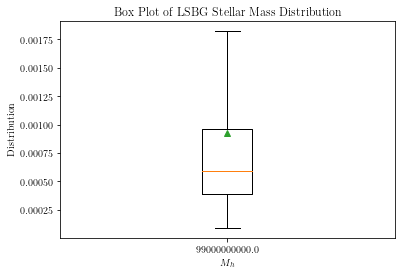

In [48]:
#Zoomed in boxplot showing our distribution of stellar masses for the SHMR
plt.boxplot(m_stellar_red/M_halo_red, vert=True, sym='',positions=np.array([M_halo_red]), showmeans=True)
plt.title('Box Plot of LSBG Stellar Mass Distribution')
plt.xlabel('$M_h$')
plt.ylabel('Distribution')
plt.show()

In [49]:
#Printing out information from the stellar mass distribution
print(np.mean(m_stellar_red))
print(np.median(m_stellar_red))
print(np.median(m_stellar_err_red))

91370150.61593145
58989714.99021852
27203148.063063525
